In [ ]:
## 环境
import sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["NUMBA_NUM_THREADS"] = "64"
os.environ["NUMBA_THREADING_LAYER"] = "omp"
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")

## 基础
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

## 必要库
from threeML import *
try:
    from hawc_hal import HAL, HealpixConeROI, HealpixMapROI
except:
    from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import mylib as my
from importlib import reload

##可选
# from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
# from threeML.utils.progress_bar import trange
# from tqdm import tqdm
# from astropy.io import fits
# from astropy.wcs import WCS
# from astropy.coordinates import SkyCoord
# from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
# from astropy.coordinates import Angle
import healpy as hp
# import traceback

## 警告
# import warnings
# np.seterr(all="ignore")
np.seterr(divide="ignore")
# warnings.simplefilter("ignore")
# silence_warnings()
# silence_logs()
# quiet_mode()
# loud_mode()
# debug_mode()

Load Mymap:  11%|█         | 4/38 [00:00<00:01, 28.32it/s]     
WARNING VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.

Load sub from Mystat: : 40it [00:00, 47.41it/s]                            

Yourlib init successfully!!!


14:41:33 INFO      Using transits contained in maptree                                                    ]8;id=267830;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=668413;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#78\78]8;;\

         INFO      Reading Maptree!                                                           ]8;id=482386;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/from_root_file.py\from_root_file.py]8;;\:]8;id=737547;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/from_root_file.py#218\218]8;;\

Load sub from Mystat: : 40it [00:19, 47.41it/s]

14:41:56 INFO      Creating singleton for                                                            ]8;id=350837;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=638608;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py#49\49]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/../../data/KM2A_DR_xsq.root                          

14:42:13 INFO      Region of Interest:                                                                   ]8;id=675524;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=804626;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#342\342]8;;\

         INFO      -------------------                                                                   ]8;id=559796;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=77090;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#343\343]8;;\

         INFO      HealpixMapROI: Center (R.A., Dec) = (83.000, 26.000), model radius: 8.000 ]8;id=761874;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/region_of_interest/healpix_map_roi.py\healpix_map_roi.py]8;;\:]8;id=209732;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/region_of_interest/healpix_map_roi.py#128\128]8;;\
                  deg, display radius: 7.000 deg, threshold = 0.50                                                 

         INFO                                                                                            ]8;id=725710;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=212631;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#346\346]8;;\

         INFO      Flat sky projection:                                                                  ]8;id=333255;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=323840;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#347\347]8;;\

         INFO      --------------------                                                                  ]8;id=788790;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=116961;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#348\348]8;;\

         INFO      Width x height 96 x 96 px                                                             ]8;id=525803;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=20498;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#350\350]8;;\

         INFO      Pixel sizes: 0.17 deg                                                                 ]8;id=968287;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=9511;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#355\355]8;;\

         INFO                                                                                            ]8;id=617692;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=796831;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#358\358]8;;\

         INFO      Response:                                                                             ]8;id=171019;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=555901;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#359\359]8;;\

         INFO      ---------                                                                             ]8;id=149445;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=536889;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#360\360]8;;\

         INFO      Response file:                                                                   ]8;id=315958;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=157974;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py#556\556]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/../../data/KM2A_DR_xsq.root                          

         INFO      Number of dec bins: 110                                                          ]8;id=13415;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=879786;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py#557\557]8;;\

         INFO      Number of energy/nHit planes per dec bin_name: 14                                ]8;id=65169;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py\response.py]8;;\:]8;id=630712;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/response/response.py#561\561]8;;\

         INFO                                                                                            ]8;id=566399;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=462771;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#364\364]8;;\

         INFO      Map Tree:                                                                             ]8;id=546147;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=733948;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#365\365]8;;\

         INFO      ----------                                                                            ]8;id=664703;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=999436;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#366\366]8;;\

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,4.204434e+06,4.201882e+06,1.000608,33977,111.393282
1,1,1024,RING,8.131919e+06,8.121699e+06,1.001258,33977,111.393282
2,2,1024,RING,4.211223e+06,4.208359e+06,1.000681,33977,111.393282
3,3,1024,RING,1.142067e+06,1.139900e+06,1.001901,33977,111.393282
4,4,1024,RING,9.720935e+04,9.619791e+04,1.010514,33977,111.393282
5,5,1024,RING,1.562645e+04,1.533239e+04,1.019179,33977,111.393282
6,6,1024,RING,8.237769e+03,8.092436e+03,1.017959,33977,111.393282
7,7,1024,RING,1.773990e+03,1.681656e+03,1.054907,33977,111.393282
8,8,1024,RING,5.349200e+02,4.854193e+02,1.101975,33977,111.393282
9,9,1024,RING,1.623700e+02,1.764329e+02,0.920293,33977,111.393282


         INFO      This Map Tree contains 1570.300 transits in the first bin                        ]8;id=363788;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=851975;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py#156\156]8;;\

         INFO      Total data size: 7.61 Mb                                                         ]8;id=5444;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=237556;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/maptree/map_tree.py#160\160]8;;\

         INFO                                                                                            ]8;id=854953;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=71511;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#370\370]8;;\

         INFO      Active energy/nHit planes (14):                                                       ]8;id=794311;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=953240;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#372\372]8;;\

         INFO      -------------------------------                                                       ]8;id=522230;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=717541;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#373\373]8;;\

         INFO      ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']            ]8;id=914409;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py\HAL.py]8;;\:]8;id=861218;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/HAL.py#374\374]8;;\

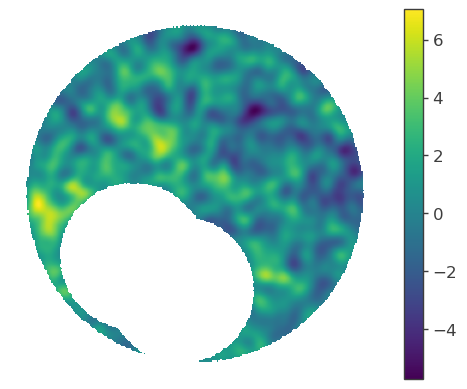

In [3]:
#####   Data Initialize

# maptree = "../../data/KM2A_all_final.root" #old catalog
# response = "../../data/KM2A_DR_all.root"

# maptree = "../../data/KM2A1234full_skymap_rcy.root"
# # maptree = "/data/home/cwy/Science/KM2A1234full_skymap_rcy_test.root"
# response = "../../data/KM2A1234full_mcpsf_DRfinal.root"

maptree = "../../data/KM2A_20240731_xsq_out.root"
response = "../../data/KM2A_DR_xsq.root"

region_name="S147"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')
# ra_S147, dec_S147 =  84.60, 28.29
ra_S147, dec_S147 =   83, 26 #84.60, 28.29
ra1,dec1=ra_S147, dec_S147

data_radius = 7.0
model_radius = 8.0

roimap = my.getmaskedroi(ra1, dec1, data_radius, [(85.78, 23.40, 3), (83.63, 22.02, 3)]) #
roi = HealpixMapROI(ra=ra1,dec=dec1, data_radius=data_radius, model_radius=model_radius, roimap=roimap) 

# roi=HealpixConeROI(ra=ra1,dec=dec1,data_radius=data_radius,model_radius=model_radius) 

KM2A = HAL("KM2A", maptree, response, roi, flat_sky_pixels_size=0.17)

#####   Data Situation
%matplotlib inline
KM2A.set_active_measurements(0, 13)
KM2A.display()

fig = KM2A.display_stacked_image(smoothing_kernel_sigma=0.25)
fig.show()
fig.savefig(f"../res/{region_name}/counts_all.png",dpi=300)

In [ ]:
my.Search(ra1, dec1, data_radius, model_radius, region_name, KM2A, roi, 4,13, fromcatalog=1, detector="KM2A", fixcatall=0)

In [4]:
Modelname="1pt_freeDGE_4-13_KM2A"
if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
    os.system(f'mkdir ../res/{region_name}/{Modelname}/')

lm = my.getcatModel(ra1, dec1, data_radius, model_radius, detector="KM2A", rtsigma = 8, rtflux = 15, rtindex = 2, rtp = 8)

# S147 = my.set_diffusemodel("S147", '/data/home/cwy/Science/3MLWCDA/Standard/res/S147/S147_HI_temp.fits', K=7.3776826e-14, Kb=(1e-17, 1e-12))

PWN = my.setsorce("PWN",84.5,28.2, k=1e-14, index=-3.6, #sigma=0.2, sb=(0,5), #sf=True, #raf=True,decf=True,
                indexb=(-4,-1),kb=(1e-19, 1e-14), #indexf=True,
                fitrange=0.5, piv=50)

Diffuse = my.set_diffusebkg( 
                ra1, dec1, data_radius, data_radius, K=1e-15, Kb=(1e-19, 1e-13), index=-3.2,
                Kf=False, indexf=False, piv=50
                )
# lm = Model(PWN, Diffuse) #S147,
# lm = Model(S147, PWN, Diffuse)
# lm.add_source(S147)
lm.add_source(PWN); lm.add_source(Diffuse)

lm.save(f"../res/{region_name}/{Modelname}/Model_init.yml", overwrite=True)
with open(f'../res/{region_name}/{Modelname}/Model_init.txt', 'w') as f:
    for key, value in lm.parameters.items():
        f.write(f'{key}: {value}\n')

lm.display(complete=True)

14:42:15 INFO      J0534P2200u in data_radius: 7.0 sf:False pf:False kf:False indexf:False             ]8;id=432476;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=783335;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#468\468]8;;\

         INFO      Spec:                                                                               ]8;id=248203;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=208518;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#560\560]8;;\
                   K=6.23e-16 kb=(4.15e-18, 9.35e-15) index=-3.19 indexb=(-5.19,-1.50)                             

         INFO      Mor: fitrange=0.09                                                                  ]8;id=201408;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=184815;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#570\570]8;;\

         WARNING   We have set the min_value of J0534P2200u.spectrum.main.Powerlaw.K to 1e-99      ]8;id=402875;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=181462;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  because there was a postive transform                                                            

         INFO      J0542P2311u in data_radius: 7.0 sf:False pf:False kf:False indexf:False             ]8;id=302193;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=581184;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#468\468]8;;\

         INFO      Spec:                                                                               ]8;id=643103;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=582370;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#560\560]8;;\
                   K=2.93e-16 kb=(1.95e-18, 4.39e-15) index=-3.74 indexb=(-5.50,-1.74)                             

         INFO      Mor:                                                                                ]8;id=385851;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=902220;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#562\562]8;;\
                   sigma=0.98 sb=(0.58,1.38) fitrange=1.12                                                         

         WARNING   We have set the min_value of J0542P2311u.spectrum.main.Powerlaw.K to 1e-99      ]8;id=286673;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=699389;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  because there was a postive transform                                                            

         WARNING   We have set the min_value of PWN.spectrum.main.Powerlaw.K to 1e-99 because      ]8;id=525610;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=171197;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  there was a postive transform                                                                    

         INFO      Set diffuse range: [173.8761882515279, 187.8761882515279] [-11.120416922412595,    ]8;id=454891;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=533790;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2061\2061]8;;\
                  11.120416922412595]                                                                              

         INFO      ra dec coner:                                                                      ]8;id=738933;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=695474;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2062\2062]8;;\

         INFO      (72.09565075083303, 27.534654967370326)                                            ]8;id=618261;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=513969;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2063\2063]8;;\

         INFO      (80.74857707241122, 16.372828783120497)                                            ]8;id=85132;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=645139;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2064\2064]8;;\

         INFO      (101.71036418428284, 27.24389435719929)                                            ]8;id=34060;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=984411;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2065\2065]8;;\

         INFO      (94.62577936465718, 39.65607009306031)                                             ]8;id=954382;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=960220;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2066\2066]8;;\

         INFO      total sr: 0.09450243804428704                                                      ]8;id=443184;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=287347;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2105\2105]8;;\
                  ratio: 0.03441567082968896                                                                       

         INFO      integration: 4.7194722588394124e-06                                                ]8;id=61531;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=865886;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2106\2106]8;;\
                  ratio: 0.037243985060463405                                                                      

         INFO      set K to: 1e-15                                                                    ]8;id=822754;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=428818;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2107\2107]8;;\

         INFO      diffuse file path: ../../data/None_dust_bkg_template.fits                          ]8;id=744473;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=797499;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#2134\2134]8;;\

         WARNING   We have set the min_value of Diffuse.spectrum.main.Powerlaw.K to 1e-99 because  ]8;id=6064;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=231133;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/astromodels/core/parameter.py#694\694]8;;\
                  there was a postive transform                                                                    

Model summary:
==============

                  N
Point sources     2
Extended sources  2
Particle sources  0

Free parameters (15):
--------------------

                                          value min_value max_value  \
J0534P2200u.position.ra                   83.61    83.522    83.698   
J0534P2200u.position.dec                  22.04    21.952    22.128   
J0534P2200u.spectrum.main.Powerlaw.K        0.0       0.0       0.0   
J0534P2200u.spectrum.main.Powerlaw.index  -3.19     -5.19      -1.5   
J0542P2311u.Gaussian_on_sphere.lon0       85.71     84.59     86.83   
J0542P2311u.Gaussian_on_sphere.lat0        23.2     22.08     24.32   
J0542P2311u.Gaussian_on_sphere.sigma       0.98      0.58      1.38   
J0542P2311u.spectrum.main.Powerlaw.K        0.0       0.0       0.0   
J0542P2311u.spectrum.main.Powerlaw.index  -3.74      -5.5     -1.74   
PWN.position.ra                            84.5      84.0      85.0   
PWN.position.dec                           28.2      27.7      28.7   
PWN.spectrum.main.Powerlaw.K                0.0       0.0       0.0   
PWN.spectrum.main.Powerlaw.index           -3.6      -4.0      -1.0   
Diffuse.spectrum.main.Powerlaw.K            0.0       0.0       0.0   
Diffuse.spectrum.main.Powerlaw.index       -3.2      -4.0      -1.0   

                                                    unit  
J0534P2200u.position.ra                              deg  
J0534P2200u.position.dec                             deg  
J0534P2200u.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
J0534P2200u.spectrum.main.Powerlaw.index                  
J0542P2311u.Gaussian_on_sphere.lon0                  deg  
J0542P2311u.Gaussian_on_sphere.lat0                  deg  
J0542P2311u.Gaussian_on_sphere.sigma                 deg  
J0542P2311u.spectrum.main.Powerlaw.K      keV-1 s-1 cm-2  
J0542P2311u.spectrum.main.Powerlaw.index                  
PWN.position.ra                                      deg  
PWN.position.dec                                     deg  
PWN.spectrum.main.Powerlaw.K              keV-1 s-1 cm-2  
PWN.spectrum.main.Powerlaw.index                          
Diffuse.spectrum.main.Powerlaw.K          keV-1 s-1 cm-2  
Diffuse.spectrum.main.Powerlaw.index                      

Fixed parameters (7):
---------------------

                                                                                    value  \
J0534P2200u.spectrum.main.Powerlaw.piv                                      50000000000.0   
J0542P2311u.spectrum.main.Powerlaw.piv                                      50000000000.0   
PWN.spectrum.main.Powerlaw.piv                                              50000000000.0   
Diffuse.SpatialTemplate_2D.K                                                          1.0   
Diffuse.SpatialTemplate_2D.hash         1389017525880140579864566943032514317764923839...   
Diffuse.SpatialTemplate_2D.ihdu                                                       0.0   
Diffuse.spectrum.main.Powerlaw.piv                                          50000000000.0   

                                       min_value max_value   unit  
J0534P2200u.spectrum.main.Powerlaw.piv      None      None    keV  
J0542P2311u.spectrum.main.Powerlaw.piv      None      None    keV  
PWN.spectrum.main.Powerlaw.piv              None      None    keV  
Diffuse.SpatialTemplate_2D.K                None      None  deg-2  
Diffuse.SpatialTemplate_2D.hash             None      None         
Diffuse.SpatialTemplate_2D.ihdu              0.0      None         
Diffuse.spectrum.main.Powerlaw.piv          None      None    keV  

Properties (2):
--------------------

                                                                       value  \
Diffuse.SpatialTemplate_2D.fits_file  ../../data/None_dust_bkg_template.fits   
Diffuse.SpatialTemplate_2D.frame                                        icrs   

                                                            allowed values  
Diffuse.SpatialTemplate_2D.fits_file                                  N

In [5]:
%matplotlib inline
result = my.fit(region_name, Modelname, KM2A, lm, 4, 13,mini="ROOT")
sources = my.get_sources(lm,result)
result[1][0]
# result[0].get_contours(J0248.Gaussian_on_sphere.lon0,39.88,44.88,30)

14:42:16 INFO      Considering 9 dec bins for extended source J0542P2311u          ]8;id=567472;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=95411;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 23.200                      ]8;id=6644;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=698538;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

         INFO      Considering 19 dec bins for extended source Diffuse             ]8;id=109076;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=428878;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 25.953                      ]8;id=723904;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=97684;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=555670;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=604807;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=708135;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=537888;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1076\1076]8;;\

FitFailed: MIGRAD did not converge. Reason: Edm is above maximum (status: 3)

In [7]:
resu = my.getresaccuracy(KM2A, lm, savepath = f"../res/{region_name}/{Modelname}/KM2A_sres.fits")
new_source_idx = np.where(resu==np.ma.max(resu))[0][0]
new_source_lon_lat=hp.pix2ang(1024,new_source_idx,lonlat=True)
print(new_source_lon_lat)

plt.figure()
hp.gnomview(resu,norm='',rot=[ra1,dec1],xsize=200,ysize=200,reso=6,title=Modelname)
plt.scatter(new_source_lon_lat[0],new_source_lon_lat[1],marker='x',color='red')
plt.show()
plt.savefig(f"../res/{region_name}/{Modelname}KM2A_res.png",dpi=300)

14:11:49 INFO      Considering 8 dec bins for extended source J0542P2311u          ]8;id=311179;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=853844;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 22.301                      ]8;id=858347;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=935951;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

         INFO      Considering 19 dec bins for extended source Diffuse             ]8;id=233758;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=356865;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#220\220]8;;\

         INFO      Central bin is bin at Declination = 25.953                      ]8;id=322562;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=908272;file:///data/home/cwy/.mylib/miniconda3/envs/3MLhal/lib/python3.9/site-packages/hawc_hal/convolved_source/convolved_extended_source.py#229\229]8;;\

FloatingPointError: invalid value encountered in sqrt

In [33]:
TSlist = ["PWN", "Diffuse"] #"S147",
TS, TSresults = my.getTSall(TSlist, region_name, Modelname, result, KM2A)
TSresults

19:41:01 INFO      TS_all: 33348.706081045944                                                         ]8;id=906352;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=135275;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1047\1047]8;;\

         INFO      llh_all: -13269.429366390761                                                       ]8;id=137640;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=259340;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1049\1049]8;;\

19:41:01 INFO      Considering 9 dec bins for extended source J0542P2311u          ]8;id=327386;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=654612;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#133\133]8;;\

         INFO      Central bin is bin at Declination = 23.201                      ]8;id=451505;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=786902;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#142\142]8;;\

         INFO      Considering 19 dec bins for extended source Diffuse             ]8;id=803021;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=12704;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#133\133]8;;\

         INFO      Central bin is bin at Declination = 25.803                      ]8;id=672976;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=496991;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#142\142]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=10406;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=961917;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1071\1071]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=809372;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=723394;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1071\1071]8;;\

19:41:32 INFO      Considering 9 dec bins for extended source J0542P2311u          ]8;id=489374;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=495126;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#133\133]8;;\

         INFO      Central bin is bin at Declination = 23.201                      ]8;id=212097;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=872261;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#142\142]8;;\

         INFO      Considering 19 dec bins for extended source Diffuse             ]8;id=641432;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=147952;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#133\133]8;;\

         INFO      Central bin is bin at Declination = 25.803                      ]8;id=19386;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=964458;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#142\142]8;;\

19:41:32 INFO      TS_PWN: 34.62351176394077                                                          ]8;id=76982;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=220250;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1052\1052]8;;\

         INFO      Considering 9 dec bins for extended source J0542P2311u          ]8;id=792873;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=624805;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#133\133]8;;\

         INFO      Central bin is bin at Declination = 23.201                      ]8;id=506406;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=551403;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#142\142]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=183051;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=621173;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1071\1071]8;;\

         INFO      set the minimizer to ROOT                                               ]8;id=58917;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=517789;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1071\1071]8;;\

19:42:07 INFO      Considering 9 dec bins for extended source J0542P2311u          ]8;id=514192;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=466012;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#133\133]8;;\

         INFO      Central bin is bin at Declination = 23.201                      ]8;id=71189;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=465512;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#142\142]8;;\

         INFO      Considering 19 dec bins for extended source Diffuse             ]8;id=322838;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=812933;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#133\133]8;;\

         INFO      Central bin is bin at Declination = 25.803                      ]8;id=382088;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=647804;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#142\142]8;;\

19:42:07 INFO      TS_Diffuse: 45.23517791115228                                                      ]8;id=77808;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=429185;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1052\1052]8;;\


100%|██████████| 2/2 [01:06<00:00, 33.03s/it]


,PWN,Diffuse,TS_all,-log(likelihood)
0,34.623512,45.235178,33348.706081,13269.429366


LHAASO:  1 83.62 22.01 1LHAASO J0534+2200u  0.0
LHAASO:  2 83.61 22.04 1LHAASO J0534+2200u   0.0
LHAASO:  3 85.71 23.2  1LHAASO J0542+2311u  0.98
LHAASO:  4 86.07 23.19  1LHAASO J0542+2311u   1.45
TeVCat:  1 80.43749999999999 21.214277777777777 VER J0521+211 0.0
TeVCat:  2 83.62874999999998 22.01236111111111 Crab 0.0145
TeVCat:  3 83.63291666666665 22.0145 Crab Pulsar 0.0
TeVCat:  4 85.77999999999999 23.4 HAWC J0543+233 0.5
PSR:  1 79.29166666666666 22.266666666666666 J0517+22
PSR:  2 82.21774999999998 22.00111111111111 J0528+2200
PSR:  3 83.63320833333333 22.01447222222222 J0534+2200
PSR:  4 84.60441666666665 28.28588888888889 J0538+2817
PSR:  5 85.15466666666666 32.127027777777776 J0540+3207
PSR:  6 85.79025 23.484722222222224 J0543+2329
PSR:  7 86.61983333333332 24.689166666666665 J0546+2441
PSR:  8 88.52087499999999 31.128055555555555 J0554+3107
SNR:  1 81.27083333333333 28.183333333333334 G178.2-04.2 0
SNR:  2 83.62916666666665 22.016666666666666 G184.6-05.8 0
SNR:  3 84.75 27.833

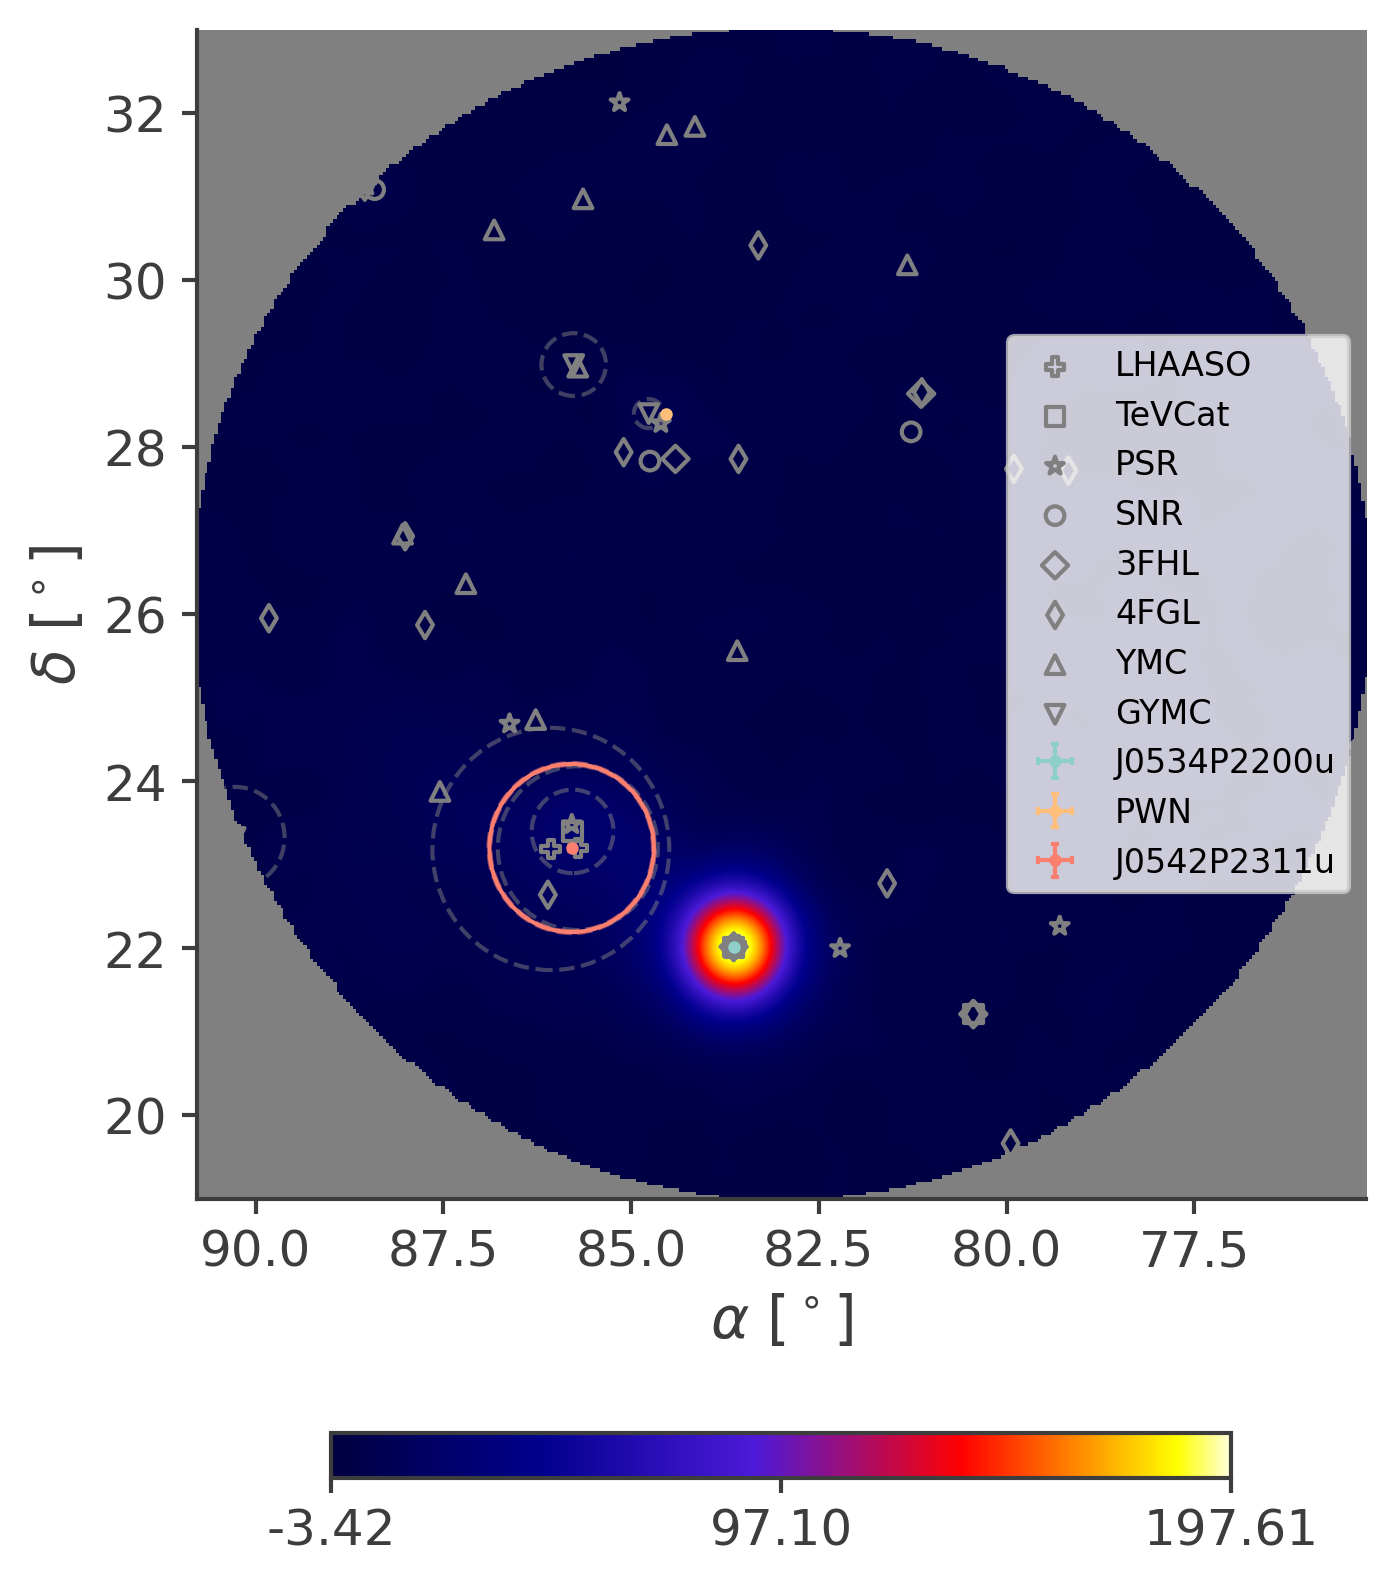

In [34]:
%matplotlib inline
sources = my.get_sources(lm,result)
sources.pop("Diffuse")

# sources={}
map2, skymapHeader = hp.read_map("../../data/fullsky_KM2A_20240131_3.5.fits.gz",h=True)
map2 = my.maskroi(map2, roi)
fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[10000],save=1, 
                # cat={ }, #
                cat={ "LHAASO": [0, "P"],"TeVCat": [0, "s"],"PSR": [0, "*"],"SNR": [0, "o"],"3FHL": [0, "D"],"4FGL": [0, "d"],"YMC": [0, "^"],"GYMC": [0, "v"],"WR": [0, "X"],"size": 20,"markercolor": "grey","labelcolor": "black","angle": 60,"catext": 1 },
                # color="Milagro"
                  color="Fermi"
                  # Drawdiff=1,legend=0
                  )

In [ ]:
my.write_resmap(region_name, Modelname, KM2A, roi, maptree, ra1, dec1, "J0057_res_all",[],[0,0])

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.0 +/- 0.7) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2936.016965
total,2936.016965


Values of statistical measures:

,statistical measures
AIC,5874.033935
BIC,5885.428546


4 0 8.341871710086707 4


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3.6 +/- 0.7) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2848.02478
total,2848.02478


Values of statistical measures:

,statistical measures
AIC,5698.049566
BIC,5709.444177


5 0 26.341926848210278 4


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3.2 +/- 0.9) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2609.992748
total,2609.992748


Values of statistical measures:

,statistical measures
AIC,5221.985503
BIC,5233.380114


6 0 13.209208627202315 4


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.5 +/- 1.0) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2195.563824
total,2195.563824


Values of statistical measures:

,statistical measures
AIC,4393.127655
BIC,4404.522266


7 0 6.078541257506004 4


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(2.9 +/- 1.4) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1372.720686
total,1372.720686


Values of statistical measures:

,statistical measures
AIC,2747.441378
BIC,2758.835989


8 0 4.617619510367149 4


Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-1.3 +/- 2.0) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,645.293307
total,645.293307


Values of statistical measures:

,statistical measures
AIC,1292.586619
BIC,1303.981230


9 0 0 4
get upper limit


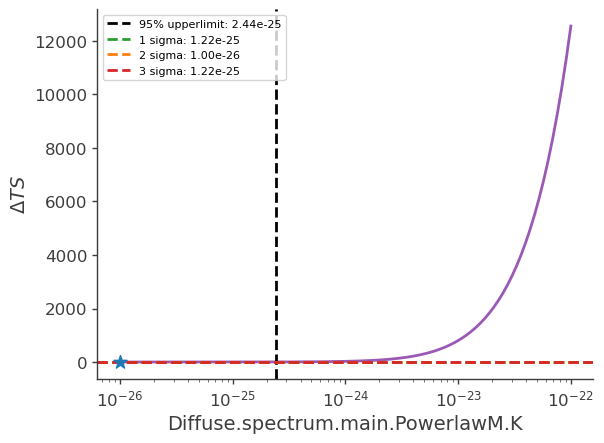

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(5.0 +/- 3.4) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,375.325028
total,375.325028


Values of statistical measures:

,statistical measures
AIC,752.650063
BIC,764.044674


10 0 2.6352446966188836 4
get upper limit


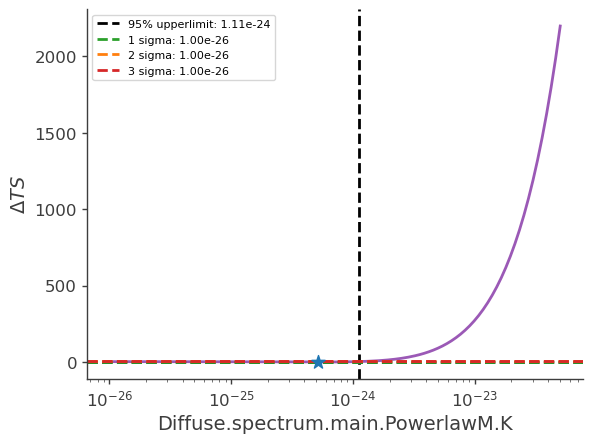

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(7 +/- 6) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,194.178791
total,194.178791


Values of statistical measures:

,statistical measures
AIC,390.357588
BIC,401.752199


11 0 1.8919601773651493 4
get upper limit


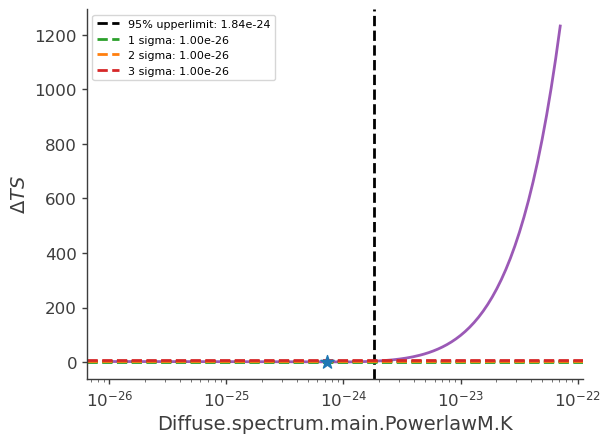

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(3 +/- 8) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,73.152334
total,73.152334


Values of statistical measures:

,statistical measures
AIC,148.304674
BIC,159.699285


12 0 0.1089775577055434 4
get upper limit


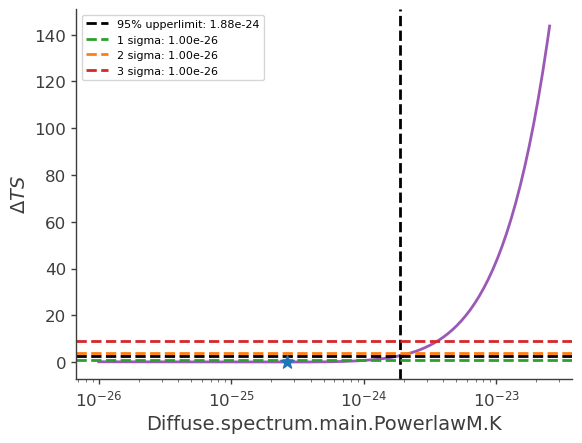

Best fit values:

,result,unit
parameter,,
Diffuse.spectrum.main.PowerlawM.K,(-0.8 +/- 1.7) x 10^-24,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,14.671049
total,14.671049


Values of statistical measures:

,statistical measures
AIC,31.342104
BIC,42.736715


13 0 0 4
get upper limit


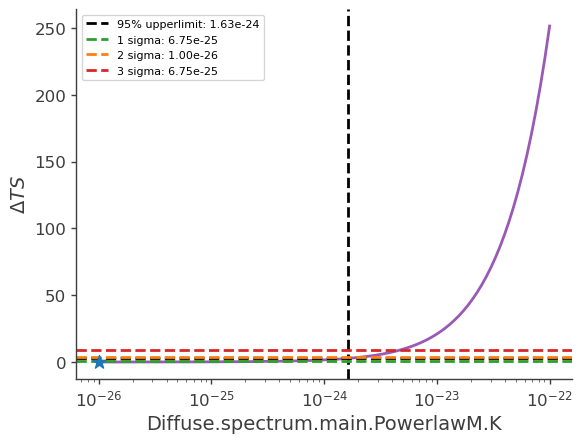

100%|██████████| 10/10 [01:09<00:00,  6.98s/it]


Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(7.9 +/- 3.0) x 10^-27,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2936.46764
total,2936.46764


Values of statistical measures:

,statistical measures
AIC,5874.935285
BIC,5886.329896


4 0 7.658412714663427 4


Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(1.1 +/- 0.4) x 10^-26,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2848.778487
total,2848.778487


Values of statistical measures:

,statistical measures
AIC,5699.556981
BIC,5710.951592


5 0 12.390884362888755 4


Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(1.6 +/- 0.5) x 10^-26,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2609.153632
total,2609.153632


Values of statistical measures:

,statistical measures
AIC,5220.307271
BIC,5231.701882


6 0 15.516693672936526 4


Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(4 +/- 5) x 10^-27,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2195.01004
total,2195.01004


Values of statistical measures:

,statistical measures
AIC,4392.020085
BIC,4403.414696


7 0 0.6002205999902799 4
get upper limit


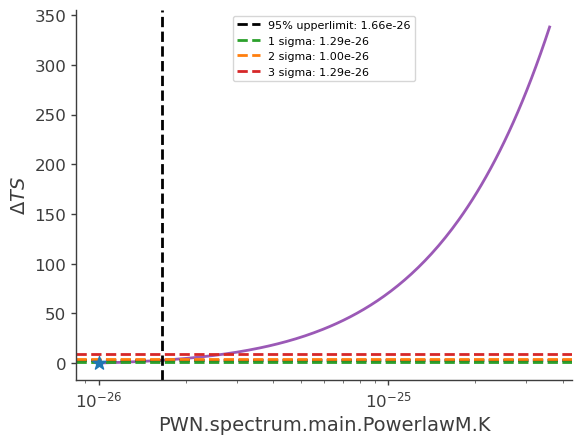

Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(1.1 +/- 1.0) x 10^-26,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1372.712285
total,1372.712285


Values of statistical measures:

,statistical measures
AIC,2747.424576
BIC,2758.819187


8 0 2.931870908383644 4
get upper limit


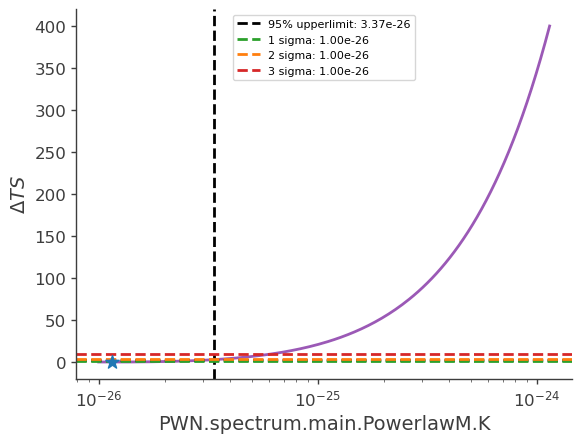

Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(0.0 +/- 1.8) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,646.607396
total,646.607396


Values of statistical measures:

,statistical measures
AIC,1295.214799
BIC,1306.609410


9 0 -0.02732824007534873 4
get upper limit


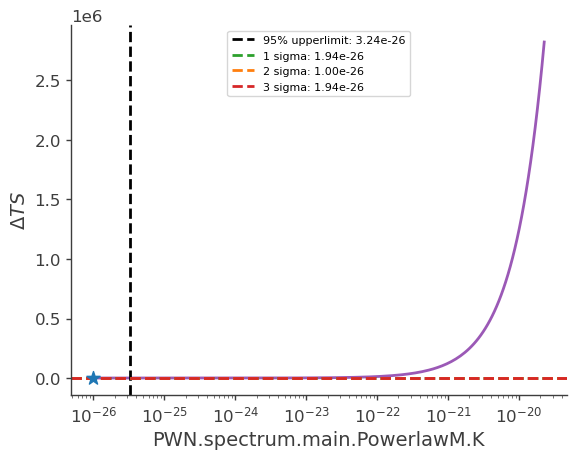

Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(3 +/- 6) x 10^-26,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,375.51768
total,375.51768


Values of statistical measures:

,statistical measures
AIC,753.035365
BIC,764.429976


10 0 0.4348197961662663 4
get upper limit


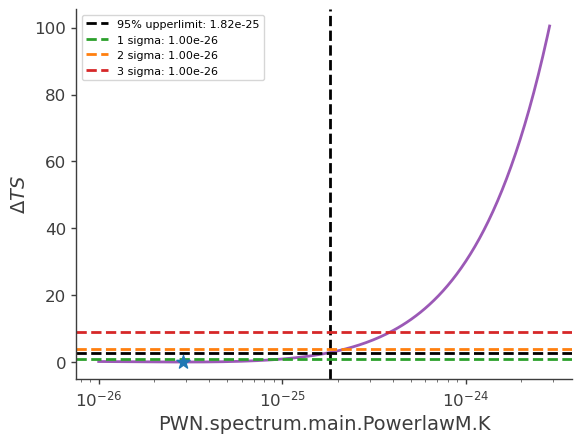

Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(0 +/- 5) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,194.463
total,194.463


Values of statistical measures:

,statistical measures
AIC,390.926006
BIC,402.320617


11 0 -0.0017404889343879404 4
get upper limit


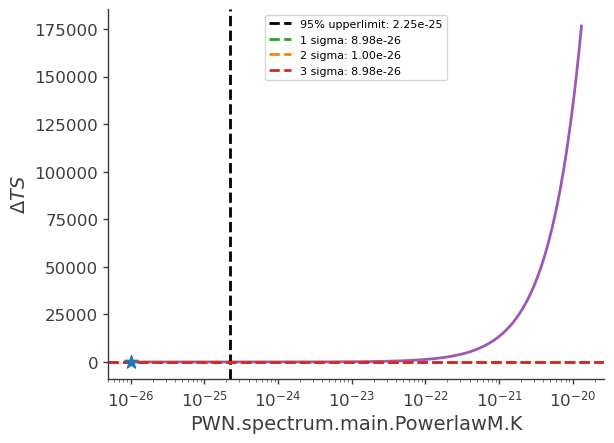

Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(0 +/- 10) x 10^-25,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,73.131596
total,73.131596


Values of statistical measures:

,statistical measures
AIC,148.263198
BIC,159.657809


12 0 -0.0004372696366203854 4
get upper limit


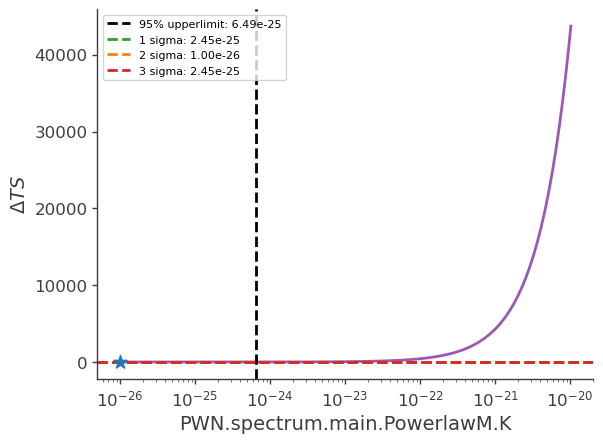

Best fit values:

,result,unit
parameter,,
PWN.spectrum.main.PowerlawM.K,(0.0 +/- 1.8) x 10^-24,1 / (cm2 keV s)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,15.358107
total,15.358107


Values of statistical measures:

,statistical measures
AIC,32.716221
BIC,44.110832


13 0 -0.00012795582299673924 4
get upper limit


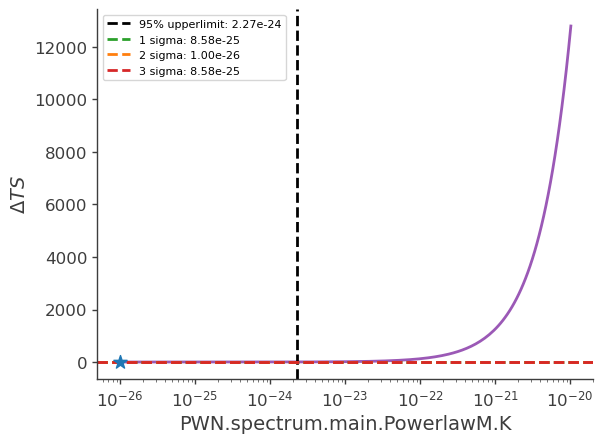

100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


In [35]:
# Flux_KM2A0, jls0  = my.getdatapoint(KM2A, lm, maptree, response, roi, "S147", ifpowerlawM=1, piv=50)
Flux_KM2A1, jls1  = my.getdatapoint(KM2A, lm, maptree, response, roi, "Diffuse", ifpowerlawM=1, piv=50, scanbin=0)
Flux_KM2A2, jls2  = my.getdatapoint(KM2A, lm, maptree, response, roi, "PWN", ifpowerlawM=1, piv=50, scanbin=0)

processing MLE analyses:   0%|          | 0/2 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]

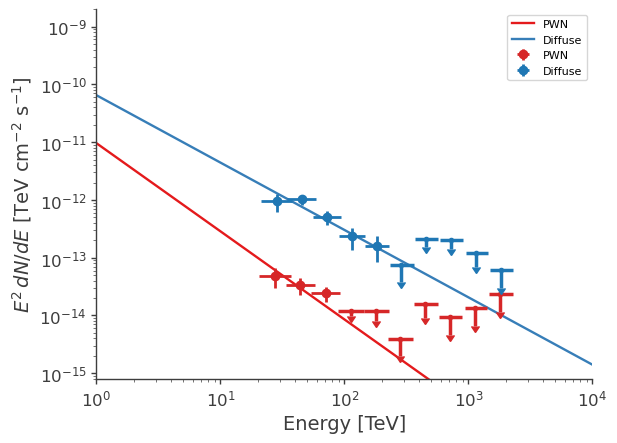

In [36]:
%matplotlib inline
import matplotlib as mpl

x_Max=10000.
x_Min=1
y_Min=0.8e-15
y_Max=2e-9
fig,ax = plt.subplots()
plot_spectra(
    result[0].results,
    sources_to_use=["PWN","Diffuse"], #,"Diffuse","ext1","ext2","ext4","ext5","ext6","ext7"| "S176",
    include_extended=True,
    ene_min=x_Min,
    ene_max=x_Max,
    num_ene=30,
    energy_unit="TeV",
    flux_unit="TeV/(s cm2)",
    subplot=ax,
    )

# my.Draw_sepctrum_points(region_name, Modelname, Flux_KM2A0,"S147","tab:red", usexerr=True)
my.Draw_sepctrum_points(region_name, Modelname, Flux_KM2A2,"PWN","tab:red", usexerr=True)
my.Draw_sepctrum_points(region_name, Modelname, Flux_KM2A1,"Diffuse","tab:blue", usexerr=True)
# my.Draw_spectrum_fromfile("/data/home/cwy/Science/3MLWCDA/Standard/res/S147/1pt+HI_freeDGE_0-5_roi6/Spectrum_PWN.txt",label="PWN WCDA",color="tab:purple", threshold=1)

# LHAASO_sensitivity = np.genfromtxt("./LHAASO_sensitivity.csv",delimiter=',')
# plt.plot(LHAASO_sensitivity[:,0],LHAASO_sensitivity[:,1]*1e-11,label="LHAASO 1yr", c="black")

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
plt.legend()
plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.pdf')

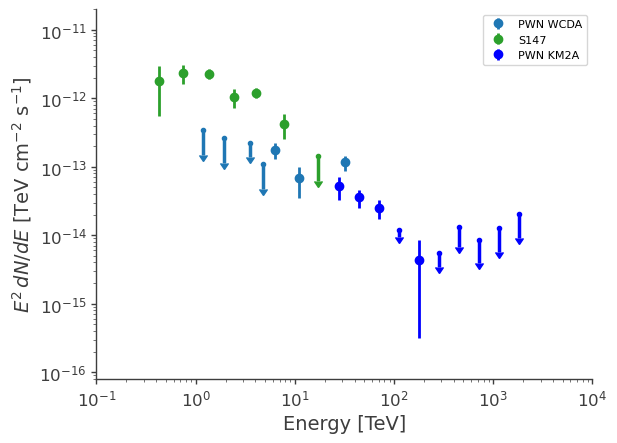

In [37]:
%matplotlib inline
import matplotlib as mpl

x_Max=10000.
x_Min=0.1
y_Min=0.8e-16
y_Max=2e-11
fig,ax = plt.subplots()

# my.Draw_sepctrum_points(region_name, Modelname, Flux_KM2A0,"S147","tab:red", usexerr=True)
# my.Draw_sepctrum_points(region_name, Modelname, Flux_KM2A2,"PWN","tab:red", usexerr=True)
# my.Draw_sepctrum_points(region_name, Modelname, Flux_KM2A1,"Diffuse","tab:blue", usexerr=True)
# my.Draw_spectrum_fromfile("/data/home/cwy/Science/3MLWCDA/Standard/res/S147/1pt+HI_freeDGE_0-5_roi6/Spectrum_PWN.txt",label="PWN WCDA",color="tab:purple", threshold=1)

my.Draw_spectrum_fromfile("/data/home/cwy/Science/3MLWCDA/Standard/res/S147/cat+1ext+1pt_freeDGE_0-6/Spectrum_PWN.txt",label="PWN WCDA",color="tab:blue", threshold=1)
my.Draw_spectrum_fromfile("/data/home/cwy/Science/3MLWCDA/Standard/res/S147/cat+1ext+1pt_freeDGE_0-6/Spectrum_S147.txt",label="S147",color="tab:green", threshold=1)
my.Draw_spectrum_fromfile("/data/home/cwy/Science/3MLWCDA/Standard/res/S147/cat+1pt_freeDGE_4-13_roi6_KM2A/Spectrum_PWN.txt",label="PWN KM2A", color="blue", threshold=1)

# my.Draw_spectrum_fromfile("/data/home/cwy/Science/3MLWCDA/Standard/res/S147/cat+1ext+1pt_freeDGE_0-6/Spectrum_PWN.txt",label="PWN WCDA",color="tab:purple", threshold=1)


# LHAASO_sensitivity = np.genfromtxt("./LHAASO_sensitivity.csv",delimiter=',')
# plt.plot(LHAASO_sensitivity[:,0],LHAASO_sensitivity[:,1]*1e-11,label="LHAASO 1yr", c="black")

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
plt.legend()
plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.pdf')